In [1]:
import cmctoolkit as cmct

import numpy as np
import matplotlib.pyplot as plt

The $\texttt{cmctoolkit}$ is a set of python functions to quickly process the globular cluster (GC) simulation data for $\texttt{Cluster Monte Carlo}$ ($\texttt{CMC}$) code, especially the large grid recently released by Kremer et al. 2020 (DOI: 10.3847/1538-4365/ab7919). An example of its usage can be found in Rui, in prep. to match GC simulations to surface brightness and velocity dispersion data.

The $\texttt{CMC Cluster Catalog}$ is publicly accessible at https://cmc.ciera.northwestern.edu/home/, where the following files can be downloaded:
* A complete list of all objects in the cluster at a given point in time, including stellar properties, positions, and velocities
* A conversion file ("$\texttt{initial.conv.sh}$") containing information for converting between code units and physical units.

The $\texttt{Catalog}$ is varied over the initial virial radius $r_v$, galactocentric distance $R_g$ (for calculation of the tidal radius), metallicity $Z$ (for stellar evolution), and initial number $N$.

The code revolves around a $\texttt{Snapshot}$ object, which takes as arguments the snapshot filename, conversion file, and optionally the distance and metallicity. In order to demonstrate some possibilities for this code, we provide a few examples by examining the $\textbf{N8-RV1-RG8-Z0.1}$ model.

## The $\texttt{Snapshot}$ Object

In [2]:
# Read snapshot 0382 of n8-rv1-rg8-z0.1
snap = cmct.Snapshot(fname='N8-RV1-RG8-Z0.1/initial.snap0382.dat.gz',
                      conv='N8-RV1-RG8-Z0.1/initial.conv.sh',
                      dist=15, # distance to cluster in kpc
                         z=0.02*0.1
                    )

# Print the simulated star catalog
print(snap.data)

              id    m[MSUN]          r        vr        vt         E  \
0            0.0  29.821064   0.031337 -0.048657  0.011852 -0.167726   
1       383270.0   0.496501   0.035258  0.388841  0.363856 -0.026968   
2       235229.0   0.125810   0.043891 -0.212199  0.245219 -0.115833   
3       130602.0   1.242000   0.048774  0.125371  0.243344 -0.130803   
4       543805.0   0.770915   0.052481 -0.181663  0.105104 -0.146151   
...          ...        ...        ...       ...       ...       ...   
682578  564437.0   0.119351  63.854536 -0.013345  0.000321 -0.007167   
682579  470918.0   0.107544  63.909288 -0.002542  0.006217 -0.007227   
682580  327456.0   0.269878  63.974174  0.007704  0.002889 -0.007208   
682581   38418.0   0.267489  64.000091 -0.012462  0.000791 -0.007161   
682582  434745.0   0.088851  64.197640  0.003873  0.002622 -0.007206   

               J  binflag    m0[MSUN]    m1[MSUN]  ...  bacc1  tacc0  tacc1  \
0       0.000371      1.0   16.283503   13.537561  ...  

One is free to easily recover the snapshot age:

In [3]:
print(snap.age) # Gyr

12.732264843402001


Behind the scenes, $\texttt{CMC}$ works in code units which are not immediately physically identifiable. Conversion between code units and physical units are encoded in the $\texttt{convert_units}$ method. Note that quantities which are dimensionally identical but applied at physically different scales are sometimes identified with two different code units. For example, there are different code units for time in terms of the cluster age and time for the purpose of calculating stellar velocities.

Startypes follow the SSE/BSE conventions of Hurley 2000, 2002:
* 0 - deeply or fully convective low mass MS star
* 1 - Main Sequence star
* 2 - Hertzsprung Gap
* 3 - First Giant Branch
* 4 - Core Helium Burning
* 5 - First Asymptotic Giant Branch
* 6 - Second Asymptotic Giant Branch
* 7 - Main Sequence Naked Helium star
* 8 - Hertzsprung Gap Naked Helium star
* 9 - Giant Branch Naked Helium star
* 10 - Helium White Dwarf
* 11 - Carbon/Oxygen White Dwarf
* 12 - Oxygen/Neon White Dwarf
* 13 - Neutron Star
* 14 - Black Hole
* 15 - Massless Supernova

0         5.931405e+31
1         9.875399e+29
2         2.502359e+29
3         2.470336e+30
4         1.533348e+30
              ...     
682578    2.373887e+29
682579    2.139049e+29
682580    5.367867e+29
682581    5.320352e+29
682582    1.767239e+29
Name: m[MSUN], Length: 682583, dtype: float64


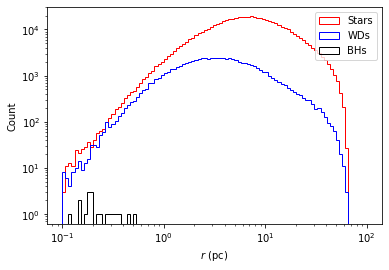

In [4]:
# Convert stellar mass from solar masses to kg
print(snap.convert_units(snap.data['m[MSUN]'], # [MSUN] indicates units already given in solar masses
                 in_unit='msun',
                out_unit='kg'))

# Plot radial distribution of stars, white dwarfs, and black holes separately for single objects
binflag = (snap.data['binflag'] == 1) # binarity flag
startype_star = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
startype_wd = np.array([10, 11, 12])
startype_bh = np.array([14])

r = snap.convert_units(snap.data['r'], # distance to cluster center in pc
               in_unit='code',
              out_unit='pc')

starflag = np.in1d(snap.data['startype'], startype_star)
wdflag = np.in1d(snap.data['startype'], startype_wd)
bhflag = np.in1d(snap.data['startype'], startype_bh)

bins = np.logspace(-1, 2, 100)

plt.hist(r[starflag & ~binflag], bins, color='r', histtype='step', label='Stars')
plt.hist(r[wdflag & ~binflag], bins, color='b', histtype='step', label='WDs')
plt.hist(r[bhflag & ~binflag], bins, color='k', histtype='step', label='BHs')

plt.legend(loc='upper right')
plt.xlabel('$r$ (pc)')
plt.ylabel('Count')
plt.xscale('log')
plt.yscale('log')

plt.show()

## Randomly Projected Profile

Here, we plot the projection onto the 2D plane of the sky of positions and velocities for single stars, white dwarfs, and black holes separately after adopting a random seed to project stars into random solid angles in the cluster (CMC assumes spherical symmetry). Unit conversion is handled automatically.

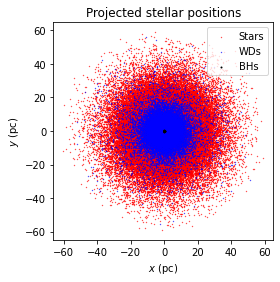

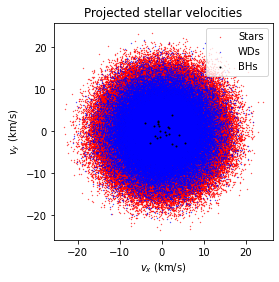

In [5]:
# Generate random solid angle positions, append additional quantities
snap.make_2d_projection(seed=8675309)

X = snap.data['x[PC]']
Y = snap.data['y[PC]']
VX = snap.data['vx[KM/S]']
VY = snap.data['vy[KM/S]']

# Plot stellar positions
plt.scatter(X[starflag & ~binflag], Y[starflag & ~binflag], c='r', s=0.1, label='Stars')
plt.scatter(X[wdflag & ~binflag], Y[wdflag & ~binflag], c='b', s=0.1, label='WDs')
plt.scatter(X[bhflag & ~binflag], Y[bhflag & ~binflag], c='k', s=1, label='BHs')

plt.gca().set_aspect('equal')

plt.legend(loc='upper right')
plt.xlabel('$x$ (pc)')
plt.ylabel('$y$ (pc)')
plt.title('Projected stellar positions')

plt.show()

# Plot stellar positions
plt.scatter(VX[starflag & ~binflag], VY[starflag & ~binflag], c='r', s=0.1, label='Stars')
plt.scatter(VX[wdflag & ~binflag], VY[wdflag & ~binflag], c='b', s=0.1, label='WDs')
plt.scatter(VX[bhflag & ~binflag], VY[bhflag & ~binflag], c='k', s=1, label='BHs')

plt.gca().set_aspect('equal')

plt.legend(loc='upper right')
plt.xlabel('$v_x$ (km/s)')
plt.ylabel('$v_y$ (km/s)')
plt.title('Projected stellar velocities')

plt.show()

## Mass Function

We plot the single star mass function below, as well as the mass function for all stars in the cluster.

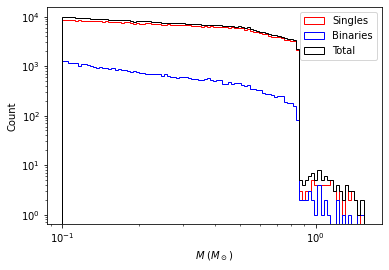

In [6]:
# Get all masses and classifications
singlestar_mass = snap.data['m[MSUN]']
binstar0_mass = snap.data['m0[MSUN]']
binstar1_mass = snap.data['m1[MSUN]']

startypes_single = snap.data['startype']
startypes_bin0 = snap.data['bin_startype0']
startypes_bin1 = snap.data['bin_startype1']

masses = np.concatenate((singlestar_mass[~binflag & starflag],
                         binstar0_mass[binflag & np.in1d(startypes_bin0, startype_star)],
                         binstar1_mass[binflag & np.in1d(startypes_bin1, startype_star)]
                        ))
binflag_tot = np.concatenate((np.zeros(len(singlestar_mass[~binflag & starflag])),
                              np.ones(len(binstar0_mass[binflag & np.in1d(startypes_bin0, startype_star)])),
                              np.ones(len(binstar1_mass[binflag & np.in1d(startypes_bin1, startype_star)]))
                             )).astype(bool)

# Plot histogram
bins = np.logspace(-1, 0.2, 100)

plt.hist(masses[~binflag_tot], bins, color='r', histtype='step', label='Singles')
plt.hist(masses[binflag_tot], bins, color='b', histtype='step', label='Binaries')
plt.hist(masses, bins, color='k', histtype='step', label='Total')

plt.legend(loc='upper right')
plt.xlabel('$M$ ($M_\odot$)')
plt.ylabel('Count')
plt.xscale('log')
plt.yscale('log')

plt.show()

Alternatively, you can call the hardcoded method to generate a mass function within some cuts and fit its slope.

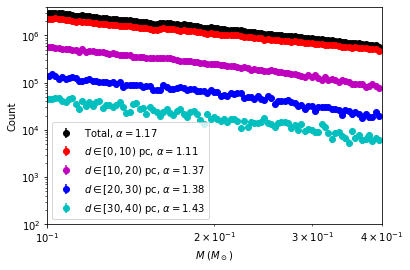

In [7]:
bin_edges = np.logspace(-1, -0.4, 100) # range: 0.1 to 0.4 solar masses
d_bins = [0, 10, 20, 30, 40] # projected distance from the cluster: d

# Make mass function
mf, e_mf = snap.make_mass_function(bin_edges,
                         startypes=startype_star)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

# Fit total mass function slope for this mass range
tot_slope = snap.fit_mass_function_slope(init_guess=1.3,
                                           min_mass=0.1,
                                           max_mass=0.4,
                                              dmin=None,
                                              dmax=None,
                                         startypes=startype_star)

plt.errorbar(bin_centers, mf, e_mf, fmt='ko',
             label=f'Total, $\\alpha={tot_slope:.2f}$')

formats = ['ro', 'mo', 'bo', 'co']

for ii in range(len(d_bins) - 1):
    # Make mass function for specific d range
    mf, e_mf = snap.make_mass_function(bin_edges,
                             startypes=startype_star,
                                  dmin=d_bins[ii],
                                  dmax=d_bins[ii+1]
                                      )
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    
    # Fit mass function slope for specific d range
    tot_slope = snap.fit_mass_function_slope(init_guess=1.3,
                                               min_mass=0.1,
                                               max_mass=0.4,
                                                   dmin=d_bins[ii],
                                                   dmax=d_bins[ii+1],
                                              startypes=startype_star)
    
    plt.errorbar(bin_centers, mf, e_mf, fmt=formats[ii],
                 label=f'$d\\in[{d_bins[ii]}, {d_bins[ii+1]})$ pc, $\\alpha={tot_slope:.2f}$')

plt.legend(loc='lower left')
plt.xlabel('$M$ ($M_\odot$)')
plt.ylabel('Count')
plt.xlim(0.1, 0.4)
plt.ylim(1e2, 4e6)
plt.xscale('log')
plt.yscale('log')

plt.show()

## Smoothed Number and Velocity Dispersion Profiles

Since $\texttt{CMC}$ assumes spherical symmetry, the $r$ radial distance parameter of a star can be thought of as parameterizing a uniform distribution of star positions within the cluster on a sphere of radius $r$. This can be projected (avoiding adding stochasticity) to form the simulation's expectation value of the number density profile, surface brightness profile, 1D velocity dispersion profile, etc. (see Rui et al., particularly Section 2.2, for details). Here, the shaded uncertainty region in the profile is assumed Poissonian, and roughly parameterizes the extent to which the profile deviates from the plotted expectation value due to stochasticity.



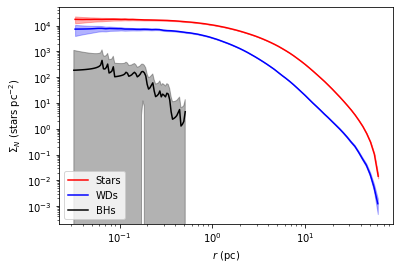

In [8]:
# Estimate and plot number density profile for stars, WDs, BHs
star_bin_center, star_profile, star_e_profile = snap.make_smoothed_number_profile(bins=80,
                                                                              min_mass=None,
                                                                              max_mass=None,
                                                                              fluxdict=None,
                                                                             startypes=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                                              min_logr=-1.5)

wd_bin_center, wd_profile, wd_e_profile = snap.make_smoothed_number_profile(bins=80,
                                                                        min_mass=None,
                                                                        max_mass=None,
                                                                        fluxdict=None,
                                                                       startypes=np.array([10, 11, 12]),
                                                                        min_logr=-1.5)

bh_bin_center, bh_profile, bh_e_profile = snap.make_smoothed_number_profile(bins=80,
                                                                        min_mass=None,
                                                                        max_mass=None,
                                                                        fluxdict=None,
                                                                       startypes=np.array([14]),
                                                                        min_logr=-1.5)

plt.plot(star_bin_center, star_profile, c='r', label='Stars')
plt.fill_between(star_bin_center, star_profile - star_e_profile,
                                  star_profile + star_e_profile, color='r', alpha=0.3)
plt.plot(wd_bin_center, wd_profile, c='b', label='WDs')
plt.fill_between(wd_bin_center, wd_profile - wd_e_profile,
                                wd_profile + wd_e_profile, color='b', alpha=0.3)
plt.plot(bh_bin_center, bh_profile, c='k', label='BHs')
plt.fill_between(bh_bin_center, bh_profile - bh_e_profile,
                                bh_profile + bh_e_profile, color='k', alpha=0.3)

plt.legend(loc='lower left')
plt.xlabel('$r$ (pc)')
plt.ylabel('$\Sigma_N$ (stars pc$^{-2}$)')
plt.xscale('log')
plt.yscale('log')

plt.show()

One can also straightforwardly generate a velocity dispersion profile.

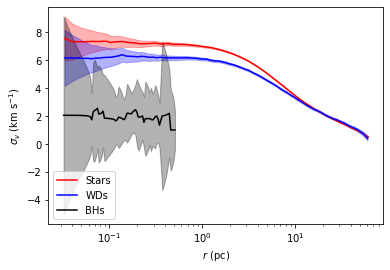

In [9]:
# Make velocity dispersion profiles
star_bin_center, star_veldisp_profile, star_e_veldisp_profile = snap.make_smoothed_veldisp_profile(bins=80,
                                                                                               min_mass=None,
                                                                                               max_mass=None,
                                                                                                   dmax=None,
                                                                                               fluxdict=None,
                                                                                              startypes=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                                                               min_logr=-1.5)

wd_bin_center, wd_veldisp_profile, wd_e_veldisp_profile = snap.make_smoothed_veldisp_profile(bins=80,
                                                                                         min_mass=None,
                                                                                         max_mass=None,
                                                                                             dmax=None,
                                                                                         fluxdict=None,
                                                                                        startypes=np.array([10, 11, 12]),
                                                                                         min_logr=-1.5)

bh_bin_center, bh_veldisp_profile, bh_e_veldisp_profile = snap.make_smoothed_veldisp_profile(bins=80,
                                                                                         min_mass=None,
                                                                                         max_mass=None,
                                                                                             dmax=None,
                                                                                         fluxdict=None,
                                                                                        startypes=np.array([14]),
                                                                                         min_logr=-1.5)

plt.plot(star_bin_center, star_veldisp_profile, c='r', label='Stars')
plt.fill_between(star_bin_center, star_veldisp_profile - star_e_veldisp_profile,
                                  star_veldisp_profile + star_e_veldisp_profile, color='r', alpha=0.3)
plt.plot(wd_bin_center, wd_veldisp_profile, c='b', label='WDs')
plt.fill_between(wd_bin_center, wd_veldisp_profile - wd_e_veldisp_profile,
                                wd_veldisp_profile + wd_e_veldisp_profile, color='b', alpha=0.3)
plt.plot(bh_bin_center, bh_veldisp_profile, c='k', label='BHs')
plt.fill_between(bh_bin_center, bh_veldisp_profile - bh_e_veldisp_profile,
                                bh_veldisp_profile + bh_e_veldisp_profile, color='k', alpha=0.3)

plt.legend(loc='lower left')
plt.xlabel('$r$ (pc)')
plt.ylabel('$\sigma_v$ (km s$^{-1}$)')
plt.xscale('log')

plt.show()

## Smoothed Surface Brightness Profile and Photometry

Making a surface brightness profile is a bit more involved, but one can specify a filter file to create this also. This requires reading in a table of filter information (e.g., $\texttt{filt_index.txt}$) as an attribute to the $\texttt{Snapshot}$ class; this table should summarize all the filter functions of relevance to the user, and should point towards filter function files (in this case, Johnson-Cousins $UBVRI$ from the SVO Profile Service, Rodrigo et al. 2017; Rodrigo & Solano 2013). The filter table is formatted to have the following columns:

* Name of filter (for purpose of calling)
* Location of filter function
* Mean wavelength (Angström)
* Min wavelength (Angström)
* Max wavelength (Angström)
* ZP spectral flux

The distance must be specified as an attribute to the $\texttt{Snapshot}$ object, in this case $15$ kpc.

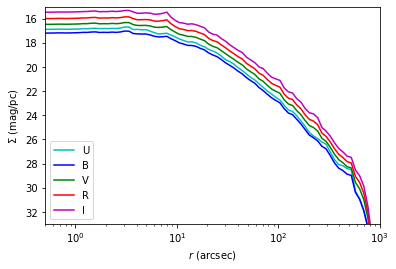

In [10]:
snap.add_photometry('filt_index.txt')

u_bincenter, u_profile = snap.make_smoothed_brightness_profile('U', bins=80,
                                                               min_mass=None, max_mass=None,
                                                               max_lum=None, fluxdict=None,
                                                               startypes=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                               min_logr=-1.5)

b_bincenter, b_profile = snap.make_smoothed_brightness_profile('B', bins=80,
                                                               min_mass=None, max_mass=None,
                                                               max_lum=None, fluxdict=None,
                                                               startypes=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                               min_logr=-1.5)

v_bincenter, v_profile = snap.make_smoothed_brightness_profile('V', bins=80,
                                                               min_mass=None, max_mass=None,
                                                               max_lum=None, fluxdict=None,
                                                               startypes=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                               min_logr=-1.5)

r_bincenter, r_profile = snap.make_smoothed_brightness_profile('R', bins=80,
                                                               min_mass=None, max_mass=None,
                                                               max_lum=None, fluxdict=None,
                                                               startypes=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                               min_logr=-1.5)

i_bincenter, i_profile = snap.make_smoothed_brightness_profile('I', bins=80,
                                                               min_mass=None, max_mass=None,
                                                               max_lum=None, fluxdict=None,
                                                               startypes=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                               min_logr=-1.5)

plt.plot(u_bincenter, u_profile, c='c', label='U')
plt.plot(b_bincenter, b_profile, c='b', label='B')
plt.plot(v_bincenter, v_profile, c='g', label='V')
plt.plot(r_bincenter, r_profile, c='r', label='R')
plt.plot(i_bincenter, i_profile, c='m', label='I')

plt.legend(loc='lower left')
plt.xlabel('$r$ (arcsec)')
plt.ylabel('$\Sigma$ (mag/pc)')
plt.xscale('log')
plt.xlim(5e-1, 1e3)
plt.ylim(33, 15)

plt.show()

## $\texttt{CMC Cluster Catalog}$

For convenience, for each snapshot with $t>10$ Gyr from all $148$ models in the $\texttt{CMC Cluster Catalog}$, we have included in this Github repository the following files within $\texttt{CMC/}$:

* $\texttt{SBP####.txt}$: Surface brightness profile, assuming a heliocentric distance of 10 pc (not 10 kpc), using the generic Johnson $V$-band filter.
* $\texttt{VDP####.txt}$: Velocity dispersion profile (radial distance given in pc), using only giant stars (types 2 through 9, inclusive).
* $\texttt{PARAM####.txt}$: Parameter file containing useful information about the population. Further information can be found on the repository readme.

Examples below will be for the same $\textbf{N8-RV1-RG8-Z0.1}$ model.

In [11]:
import glob
from astropy.io import ascii

sbp_files = glob.glob('CMC/N8-RV1-RG8-Z0.1/SBP*.txt')
sbp_files.sort()
snapno = [int(sbp_files[ii].split('SBP')[-1].split('.txt')[0]) for ii in range(len(sbp_files))]

sbp = [ascii.read(f'CMC/N8-RV1-RG8-Z0.1/SBP{str(snapno[ii]).zfill(4)}.txt') for ii in range(len(snapno))]
vdp = [ascii.read(f'CMC/N8-RV1-RG8-Z0.1/VDP{str(snapno[ii]).zfill(4)}.txt') for ii in range(len(snapno))]
param = [ascii.read(f'CMC/N8-RV1-RG8-Z0.1/PARAM{str(snapno[ii]).zfill(4)}.txt') for ii in range(len(snapno))]

ages = np.array([param[ii][np.where(param[ii]['col1'] == 'age')]['col2'][0] for ii in range(len(param))])

Below are the $V$-band surface brightness profiles and velocity dispersion profiles of included $\textbf{N8-RV1-RG8-Z0.1}$ snapshots. Cluster ages are encoded within the relevant $\texttt{PARAM####.txt}$ file. The $V$-band brightness is computed as if it is at a distance $D=10$ pc (unrealistically), and is intended to be scaled to a realistic globular cluster distance as needed.

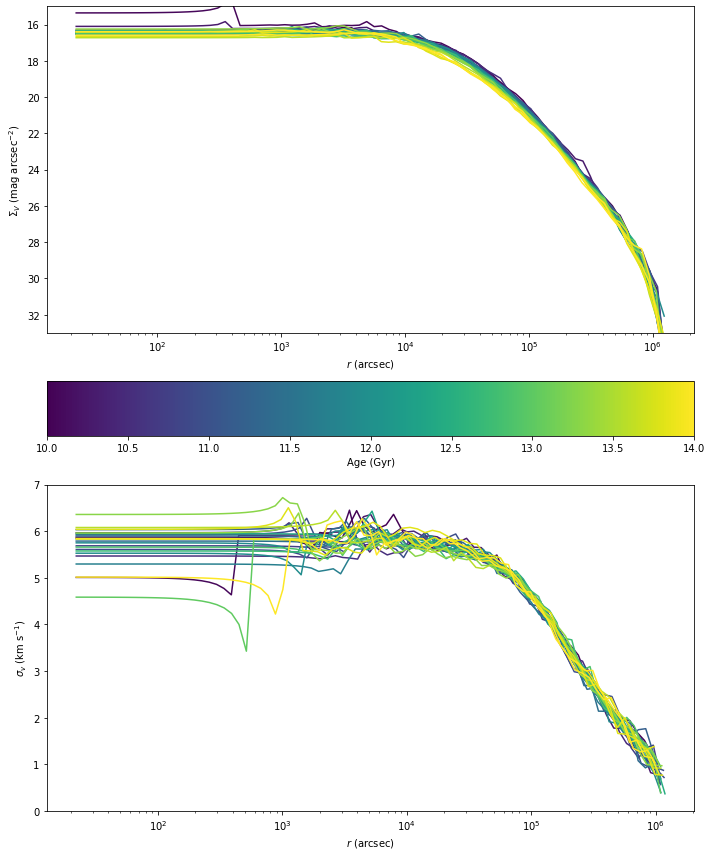

In [12]:
import matplotlib

min_age = 10
max_age = 14

f, (ax1, cax, ax2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [6, 1, 6]})
f.set_size_inches(10, 12)

for ii in range(len(snapno)):
    color = matplotlib.cm.viridis((ages[ii] - min_age) / (max_age - min_age))
    ax1.plot(sbp[ii]['col1'], sbp[ii]['col2'], color=color)

ax1.set_xlabel('$r$ (arcsec)')
ax1.set_ylabel('$\Sigma_V$ (mag arcsec$^{-2}$)')
ax1.set_xscale('log')
ax1.set_ylim(33, 15)

cmap = matplotlib.cm.viridis
norm = matplotlib.colors.Normalize(vmin=min_age, vmax=max_age)
matplotlib.colorbar.ColorbarBase(cax, cmap=cmap,
                                      norm=norm,
                               orientation='horizontal')
cax.set_xlabel('Age (Gyr)')

for ii in range(len(snapno)):
    color = matplotlib.cm.viridis((ages[ii] - min_age) / (max_age - min_age))
    ax2.plot(206265 * vdp[ii]['col1'] / 10, vdp[ii]['col2'], color=color)

ax2.set_xlabel('$r$ (arcsec)')
ax2.set_ylabel('$\sigma_v$ (km s$^{-1}$)')
ax2.set_xscale('log')
ax2.set_ylim(0, 7)

plt.tight_layout()


plt.show()

Here also are the neutron stars, white dwarfs, and black hole binaries as a function of time, as examples of what is contained in $\texttt{PARAM####.txt}$.

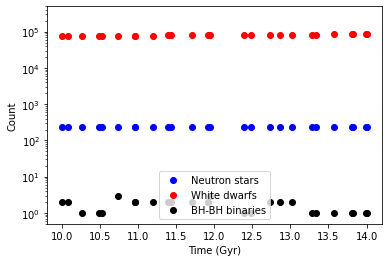

In [13]:
NNS = np.array([param[ii][np.where(param[ii]['col1'] == 'N_13')]['col2'][0] for ii in range(len(param))]) # BSS
N10 = np.array([param[ii][np.where(param[ii]['col1'] == 'N_10')]['col2'][0] for ii in range(len(param))]) # He WDs
N11 = np.array([param[ii][np.where(param[ii]['col1'] == 'N_11')]['col2'][0] for ii in range(len(param))]) # CO WDs
N12 = np.array([param[ii][np.where(param[ii]['col1'] == 'N_12')]['col2'][0] for ii in range(len(param))]) # ONe WDs
Nbin14 = np.array([param[ii][np.where(param[ii]['col1'] == 'Nbin_14_14')]['col2'][0] for ii in range(len(param))]) # BH-BH binaries

plt.scatter(ages, NNS, c='b', label='Neutron stars')
plt.scatter(ages, N10+N11+N12, c='r', label='White dwarfs')
plt.scatter(ages, Nbin14, c='k', label='BH-BH binaries')

plt.legend()
plt.xlabel('Time (Gyr)')
plt.ylabel('Count')
plt.yscale('log')
plt.ylim(0.5, 5e5)

plt.show()

## Comparison of Models to Data

We provide an example of locating the best-fitting snapshot within the $\texttt{CMC Cluster Catalog}$ via the surface brightness and velocity dispersion profiles (SBPs and VDPs), using NGC 6397 as a characteristic example.

The observed $V$-band SBP for NGC 6397 is given by Trager et al. 1995, and the VDP is given by a combination of radial velocity and proper motion measurements from Watkins et al. 2015, Baumgardt et al. 2018, and Baumgardt et al. 2019. The $E(B-V)$ is given by the Harris 1995 catalog of globular clusters, 2010 edition (with the Cardelli extinction law assumed), and the distance is given by Baumgardt et al. 2019 (from Gaia proper motions).

We restrict to the portion of the grid with $R_g$ and $Z$ closest to NGC 6397. For each snapshot, we calculate a $\tilde{\chi}^2_{\mathrm{SBP}}=\chi^2_{\mathrm{SBP}}/N_{\mathrm{SBP}}$ and $\tilde{\chi}^2_{\mathrm{VDP}}=\chi^2_{\mathrm{VDP}}/N_{\mathrm{VDP}}$, with overall model fitness estimated as $\max(\tilde{\chi}^2_{\mathrm{SBP}},\tilde{\chi}^2_{\mathrm{VDP}})$ (see Rui et al. 2019).

In [14]:
import glob
from astropy.table import Table
from scipy.interpolate import interp1d

E_BV = 0.18 # Harris 1996, 2010 edition
dist = 2.44 # Baumgardt et al. 2019, kpc
Av = 3.1 * E_BV # Cardelli 1989

# Pull all snapshots to be searched
sbp_files = glob.glob('CMC/N*-RV*-RG8-Z0.01/sbp*')
vdp_files = [sbp_files[ii].replace('SBP', 'VDP') for ii in range(len(sbp_files))]
param_files = [sbp_files[ii].replace('SBP', 'PARAM') for ii in range(len(sbp_files))]

# Read data SBP, VDP
# SBP uncertainty calculation follows that of McLaughlin & van der Marel 2005,
# and we remove points with infinite uncertainty ("goodness" 0)
obs_sbp = Table.read('ngc6397data/ngc6397sbp.txt', format='ascii')
obs_vdp = Table.read('ngc6397data/ngc6397vdp.txt', format='ascii')

obs_sbp = obs_sbp[~np.isnan(obs_sbp['e_s[MAG/ARCSEC2]'])]

# Calculate normalized chi square on all files
sbp_rchisq_list = np.array([])
vdp_rchisq_list = np.array([])

for ii in range(len(sbp_files)):
    sbp_ii = Table.read(sbp_files[ii], format='ascii')
    vdp_ii = Table.read(vdp_files[ii], format='ascii')
    
    # Convert quantities to proper distances
    sbp_r = sbp_ii['col1'] * 0.01 / dist
    vdp_r = vdp_ii['col1'] * 206265 / (1e3 * dist)
    
    # Interpolate SBP and VDP to calculate chisq
    sbp_interp = interp1d(sbp_r, Av + sbp_ii['col2'], bounds_error=False, fill_value=(sbp_ii['col2'][0], 0))
    vdp_interp = interp1d(vdp_r, vdp_ii['col2'], bounds_error=False, fill_value=(vdp_ii['col2'][0], 0))
    
    sbp_chisq = np.sum((obs_sbp['s[MAG/ARCSEC2]'] - sbp_interp(obs_sbp['r[ARCSEC]'])) ** 2 / obs_sbp['e_s[MAG/ARCSEC2]'] ** 2)
    
    data_above = np.where(obs_vdp['sig[KM/S]'] > vdp_interp(obs_vdp['r[ARCSEC]'])) # treat upper and lower error bars differently
    data_below = np.where(obs_vdp['sig[KM/S]'] < vdp_interp(obs_vdp['r[ARCSEC]']))
    vdp_chisq1 = np.sum((obs_vdp['sig[KM/S]'][data_above] - vdp_interp(obs_vdp['r[ARCSEC]'][data_above])) ** 2 / obs_vdp['el_sig[KM/S]'][data_above] ** 2)
    vdp_chisq2 = np.sum((obs_vdp['sig[KM/S]'][data_below] - vdp_interp(obs_vdp['r[ARCSEC]'][data_below])) ** 2 / obs_vdp['eu_sig[KM/S]'][data_below] ** 2)
    
    sbp_rchisq = sbp_chisq / len(obs_sbp)
    vdp_rchisq = (vdp_chisq1 + vdp_chisq2) / len(obs_vdp)
    
    sbp_rchisq_list = np.append(sbp_rchisq_list, sbp_rchisq)
    vdp_rchisq_list = np.append(vdp_rchisq_list, vdp_rchisq)
    
    if (ii+1) % 100 == 0:
        print(f'Done {ii+1} snapshots of {len(sbp_files)}')

Done 100 snapshots of 804
Done 200 snapshots of 804
Done 300 snapshots of 804
Done 400 snapshots of 804
Done 500 snapshots of 804
Done 600 snapshots of 804
Done 700 snapshots of 804
Done 800 snapshots of 804


We can now plot snapshots with $\max(\tilde{\chi}^2_{\mathrm{SBP}},\tilde{\chi}^2_{\mathrm{VDP}})<10$ over the data to ensure a good fit, and then subsequently examine the masses and mass-to-light ratios of those snapshots.

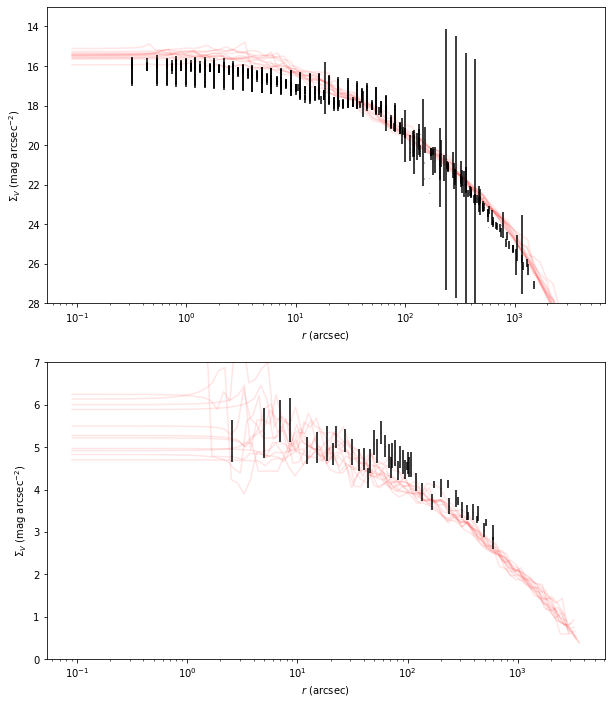

In [17]:
good = np.where(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0) < 10)

f, (ax1, ax2) = plt.subplots(2, 1)
f.set_size_inches(10, 12)

ax1.errorbar(obs_sbp['r[ARCSEC]'], obs_sbp['s[MAG/ARCSEC2]'], obs_sbp['e_s[MAG/ARCSEC2]'], fmt='ko', ms=0.1, zorder=100)

for ii in range(len(good[0])):
    sbp_t = Table.read(np.array(sbp_files)[good][ii], format='ascii')
    
    sbp_r = sbp_t['col1'] * 0.01 / dist
    sbp_s = sbp_t['col2'] + Av
    
    ax1.plot(sbp_r, sbp_s, c='r', alpha=0.1)

ax1.set_xlabel('$r$ (arcsec)')
ax1.set_ylabel('$\Sigma_V$ (mag arcsec$^{-2}$)')
ax1.set_xscale('log')
ax1.set_ylim(28, 13)

ax2.errorbar(obs_vdp['r[ARCSEC]'], obs_vdp['sig[KM/S]'], [obs_vdp['el_sig[KM/S]'], obs_vdp['eu_sig[KM/S]']], fmt='ko', ms=0.1, zorder=100)

for ii in range(len(good[0])):
    vdp_t = Table.read(np.array(vdp_files)[good][ii], format='ascii')
    
    vdp_r = vdp_t['col1'] * 206265 / (1e3 * dist)
    vdp_s = vdp_t['col2']
    
    ax2.plot(vdp_r, vdp_s, c='r', alpha=0.1)

ax2.set_xlabel('$r$ (arcsec)')
ax2.set_ylabel('$\Sigma_V$ (mag arcsec$^{-2}$)')
ax2.set_xscale('log')
ax2.set_ylim(0, 7)

plt.show()

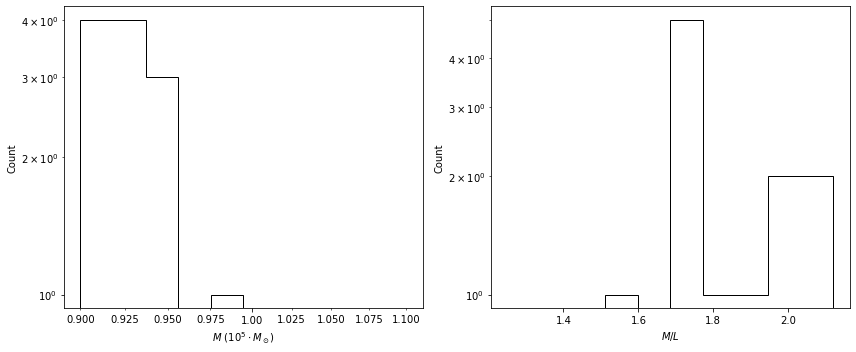

In [18]:
import matplotlib.ticker as mticker

# Find distributions of M and M/L
M_list = np.array([])
ML_list = np.array([])

plt.figure(figsize=(12, 5))

for ii in range(len(good[0])):
    param_t = Table.read(np.array(param_files)[good][ii], format='ascii')
    
    M = param_t[param_t['col1'] == 'Mtot']['col2'][0] / 1e5
    ML = M * 1e5 / param_t[param_t['col1'] == 'Ltot']['col2'][0]
    
    M_list = np.append(M_list, M)
    ML_list = np.append(ML_list, ML)

ax = plt.subplot(121)
M_bins = np.logspace(np.log10(0.9), np.log10(1.1), 11)
plt.hist(M_list, M_bins, color='k', histtype='step')
plt.xlabel('$M$ ($10^5\cdot M_\odot$)')
plt.ylabel('Count')
plt.xscale('log')
plt.yscale('log')
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())

plt.subplot(122)

ML_bins = np.linspace(1.25, 2.12, 11)
plt.hist(ML_list, ML_bins, color='k', histtype='step')
plt.xlabel('$M/L$')
plt.ylabel('Count')
plt.yscale('log')

plt.tight_layout()

plt.show()